# 使用Gluon对CIFAR10进行分类

In [1]:
import mxnet as mx
import numpy as np
import utils
import shutil
import os
import logging
logging.basicConfig(level=logging.INFO)

from mxnet import nd
from mxnet import gluon
from mxnet import image 
from mxnet import metric
from mxnet import autograd

%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

mx.random.seed(2018)

## 整理数据

In [2]:
def reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio):
    # 整理label
    with open(os.path.join(data_dir, label_file), 'r') as f:
        label_file = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in label_file]
        idx_label = dict((int(idx), label) for idx, label in tokens)
    labels = set(idx_label.values())
    
    # 设置验证集比例
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    num_train_tuning = num_train * (1 - valid_ratio)
    assert 0 < num_train_tuning < num_train
    num_train_tuning_per_label = num_train_tuning // len(labels)
    
    # 整理训练集和验证集
    label_count = dict()
    def mkdir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
            
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        train_label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', train_label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
                   os.path.join(data_dir, input_dir, 'train_valid', train_label))
        # 划分训练集和验证集
        if train_label not in label_count or label_count[train_label] < num_train_tuning_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'train', train_label))
            label_count[train_label] = label_count.get(train_label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'valid', train_label))
    
    # 整理测试集
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):  
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                   os.path.join(data_dir, input_dir, 'test', 'unknown'))

In [3]:
data_dir = 'data/kaggle_cifar10'
train_dir = 'train'
test_dir = 'test'
input_dir = 'train_valid_test'
label_file = 'trainLabels.csv'
valid_ratio = .1

if not os.path.exists(os.path.join(data_dir, input_dir, test_dir)):
    reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio)

## 读取数据并增广

In [4]:
train_augs = [
    # 该值为计算得出
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4456]), 
                            std=nd.array([0.2023, 0.1994, 0.2010])),
    image.HorizontalFlipAug(.6),
    # image.RandomSizedCropAug((32, 32), 0.8, (0.5, 2))
    # image.BrightnessJitterAug(.5),
    # image.ColorJitterAug
]

test_augs = [
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4465]), 
                            std=nd.array([0.2023, 0.1994, 0.2010]))
]

def transform(data, label, augs):
    img = data.astype(np.float32)
    for aug in augs:
        img = aug(img)
    img = img.clip(0, 255).transpose((2,0,1)) / 255
    return img, nd.array([label]).asscalar().astype(np.float32)

############################################################################
def transform_train(data, label):
    im = data.astype('float32') / 255
    im = nd.transpose(im, (2,0,1))
    im = nd.expand_dims(im, axis=0)
    im = nd.pad(im, pad_width=(0,0,0,0,4,4,4,4), constant_value=0, mode='constant')[0]
    im = nd.transpose(im, (1,2,0))
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0,
                        rand_crop=True, rand_resize=True, rand_mirror=True,
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]),
                        brightness=0, contrast=0,
                        saturation=0, hue=0,
                        pca_noise=0, rand_gray=0, inter_method=2)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32),
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def padding(data):
    data = nd.pad(data, pad_width=(0,0,0,0,2,2,2,2), constant_value=0, mode='constant')
    
############################################################################

input_str = data_dir + '/' + input_dir + '/'

# 读取数据
train_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train', transform=transform_train)
valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'valid', transform=transform_test)
train_valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train_valid', transform=transform_train)
test_ds = gluon.data.vision.ImageFolderDataset(input_str + 'test', transform=transform_test)

batch_size = 64
train_data = gluon.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
train_valid_data = gluon.data.DataLoader(train_valid_ds, batch_size=batch_size, last_batch='keep')
test_data = gluon.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, last_batch='keep')

(64, 3, 32, 32)


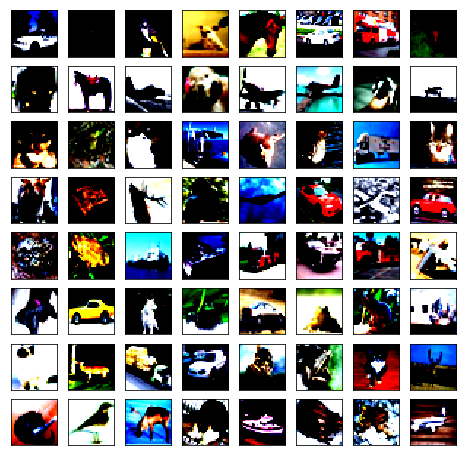

In [5]:
for data, label in valid_data:
    print(data.shape)
    break

utils.show_images(data.transpose((0,2,3,1)), 8, 8, figsize=(8,8))

## DenseNet-BC Depth=190 K=40 

In [2]:
def BN_ReLU_Conv(num_filters, kernel_size, strides=1, padding=0, erase_relu=False):
    '''
    num_filters : int
        the output channel of this module
    kernel_size : int or tuple
        conv kernel
    strides : int or tuple
        conv strides
    padding : int or tuple
        conv padding
    erase_relu : bool
        whethr erase the relu activation
    '''
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(gluon.nn.BatchNorm(axis=1, epsilon=2e-5))
        if erase_relu:
            net.add(gluon.nn.Activation('relu'))
        net.add(gluon.nn.Conv2D(num_filters, kernel_size=kernel_size, strides=strides, 
                                padding=padding, use_bias=False))
    return net

'''
BasicBlock
'''
class BasicBlock(gluon.nn.HybridBlock):
    def __init__(self, growth_rate, strides, bottleneck=False, drop_rate=0.0, **kwargs):
        '''
        growth_rate : int
        strides : step
        bottleneck : bool
        drop_rate : float
        '''
        super().__init__(**kwargs)
        blk = self.blk = gluon.nn.HybridSequential()
        with self.name_scope():
            if bottleneck:
                blk.add(BN_ReLU_Conv(int(growth_rate * 4), kernel_size=1))
                if drop_rate > 0.0:
                    blk.add(gluon.nn.Dropout(drop_rate))
                blk.add(BN_ReLU_Conv(int(growth_rate), kernel_size=3, strides=strides, padding=1))
                if drop_rate > 0.0:
                    blk.add(gluon.nn.Dropout(drop_rate))
            else:
                blk.add(BN_ReLU_Conv(int(growth_rate), kernel_size=3, strides=1))
                if drop_rate > 0.0:
                    blk.add(gluon.nn.Dropout(drop_rate))
                    
    def hybrid_forward(self, F, X):
        out = self.blk(X)
        return out
    
'''
DenseBlock
'''
class DenseBlock(gluon.nn.HybridBlock):
    def __init__(self, num_units, growth_rate, strides=1, bottleneck=False, drop_rate=0.0, **kwargs):
        '''
        num_units : int 
            each denseblock have num_units basicblock
        growth_rate : int
            the output channel of the 
        '''
        super().__init__(**kwargs)
        net = self.net = gluon.nn.HybridSequential()
        with self.name_scope():
            for i in range(num_units):
                net.add(BasicBlock(growth_rate, strides=strides, bottleneck=bottleneck, drop_rate=drop_rate))
    
    def hybrid_forward(self, F, X):
        for i, blk in enumerate(self.net):
            out = blk(X)
            X = F.concat(X, out, dim=1)
        return X
    
'''
TransitionBlock
'''
class TransitionBlock(gluon.nn.HybridBlock):
    def __init__(self, num_filter, strides=1, drop_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        trans = self.trans = gluon.nn.HybridSequential()
        with self.name_scope():
            trans.add(BN_ReLU_Conv(num_filter, kernel_size=1, strides=strides))
            if drop_rate > 0.0:
                trans.add(gluon.nn.Dropout(drop_rate))
            trans.add(gluon.nn.AvgPool2D(pool_size=2, strides=2))
    
    def hybrid_forward(self, F, X):
        out = self.trans(X)
        return out
    
class DenseNet(gluon.nn.HybridBlock):
    def __init__(self, depth, num_stages, growth_rate, num_classes, data_type, reduction=0.5, 
                 bottleneck=False, drop_rate=0.0, debug=False, **kwargs):
        super().__init__(**kwargs)
        self.debug = debug
        
        if (depth - 4) % 3:
            raise Exception("Invalid Error!")
        
        if data_type == 'cifar':
            units = [(depth - 4) // 6 if bottleneck else 3] * num_stages
        else:
            raise ValueError('Not Implementation {} yet.'.format(data_type))
            
        num_units = len(units)
        assert(num_units == num_stages)
        n_channels = init_channels = 16 if data_type=="cifar" else 2 * growth_rate
        densenet = self.densenet = gluon.nn.HybridSequential()
        with self.name_scope():
            blk1 = gluon.nn.HybridSequential()
            blk1.add(gluon.nn.BatchNorm(axis=1, epsilon=2e-5))
            if data_type == 'cifar':
                blk1.add(gluon.nn.Conv2D(init_channels, kernel_size=3, padding=1, use_bias=False))
            elif data_type == 'imagenet':
                blk1.add(gluon.nn.Conv2D(init_channels, kernel_size=7, strides=2, padding=3, use_bias=False))
                blk1.add(gluon.nn.BatchNorm(axi=1, epsilon=2e-5))
                blk1.add(gluon.nn.Activation('relu'))
                blk1.add(gluon.nn.MaxPool2D(pool_size=3, strides=2, padding=1))
            densenet.add(blk1)
    
            for i in range(num_stages-1):
                blk2 = gluon.nn.HybridSequential()
                blk2.add(DenseBlock(units[i], growth_rate, bottleneck=bottleneck, drop_rate=drop_rate))
                # count channels to prepare for the transition block
                n_channels += units[i] * growth_rate
                n_channels = int(np.floor(n_channels * reduction))
                blk2.add(TransitionBlock(n_channels, strides=1, drop_rate=drop_rate))
                densenet.add(blk2)
            densenet.add(DenseBlock(units[num_stages-1], growth_rate, bottleneck=bottleneck, drop_rate=drop_rate))
            
            blk3 = gluon.nn.HybridSequential()
            blk3.add(
                gluon.nn.BatchNorm(axis=1, epsilon=2e-5),
                gluon.nn.Activation('relu')
            )
            densenet.add(blk3)
            
            blk4 = gluon.nn.HybridSequential()
            blk4.add(
                gluon.nn.GlobalAvgPool2D(),
                gluon.nn.Dense(num_classes)
            )
            densenet.add(blk4)
            
    def hybrid_forward(self, F, X):
        out = X
        for i, blk in enumerate(self.densenet):
            out = blk(out)
            # if self.debug:
                # print("blk {} : {}".format(i+1, out.shape))
        return out

In [7]:
from time import time

def train(net, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx):
    assert isinstance(ctx, mx.Context)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    niter = 0
    moving_loss = .0
    smoothing_constant = .9
    
    if valid_data is not None:
        best_valid_acc = .0
    for epoch in range(num_epochs):
        if 0 <= epoch <= 1:
            trainer.set_learning_rate(0.01)
        if epoch == 2:
            trainer.set_learning_rate(0.1)
        if epoch == 150:
            trainer.set_learning_rate(0.01)
        if epoch == 225:
            trainer.set_learning_rate(0.001)
        start = time()
        for data, label in train_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                l = loss(output, label)
            l.backward()
            trainer.step(data.shape[0])    
            
            niter += 1   
            curr_loss = nd.mean(l).asscalar()
            moving_loss = smoothing_constant * moving_loss + (1-smoothing_constant) * curr_loss
            estimated_loss = moving_loss / (1 - smoothing_constant**niter)
        
        train_acc = utils.evaluate_accuracy_gluon(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc, valid_loss = utils.evaluate_accuracy_gluon(valid_data, net, ctx, loss_avg=True)
            print("[Epoch %d] Train Moving Loss : %.5f, Test Loss : %.5f, Train Acc : %.5f, Test Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss, valid_loss, train_acc, valid_acc, time() - start))

            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                net.save_params('densenet-cifar10-%d.params' % (epoch))
        else:
            print("[Epoch %d] Train Moving Loss : %.5f, Train Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss,train_acc, time() - start))

In [8]:
num_epochs = 200
lr = 0.1
wd = 1e-4
lr_period = 50
lr_decay = .2


ctx = mx.gpu()
symbol = DenseNet(depth=100, num_stages=3, growth_rate=12, num_classes=10, data_type='cifar', 
                  bottleneck=True, drop_rate=0.2, debug=True)
symbol.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(rnd_type='gaussian', factor_type='in', magnitude=2.))
symbol.hybridize()
train(symbol, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx)

[Epoch 0] Train Moving Loss : 2.03167, Test Loss : 1.94023, Train Acc : 0.26131, Test Acc : 0.27220, Time Consume 1204.935000 s.
[Epoch 1] Train Moving Loss : 1.98423, Test Loss : 1.78902, Train Acc : 0.29282, Test Acc : 0.33960, Time Consume 825.431000 s.
[Epoch 2] Train Moving Loss : 1.87538, Test Loss : 1.74104, Train Acc : 0.30933, Test Acc : 0.35100, Time Consume 823.120500 s.
[Epoch 3] Train Moving Loss : 1.78746, Test Loss : 1.73368, Train Acc : 0.31687, Test Acc : 0.35140, Time Consume 825.642000 s.
[Epoch 4] Train Moving Loss : 1.79030, Test Loss : 1.64339, Train Acc : 0.35291, Test Acc : 0.40140, Time Consume 818.570000 s.
[Epoch 5] Train Moving Loss : 1.76589, Test Loss : 1.57638, Train Acc : 0.38100, Test Acc : 0.43360, Time Consume 815.571000 s.
[Epoch 6] Train Moving Loss : 1.69263, Test Loss : 1.60848, Train Acc : 0.35320, Test Acc : 0.40540, Time Consume 814.303000 s.
[Epoch 7] Train Moving Loss : 1.73189, Test Loss : 1.58216, Train Acc : 0.38736, Test Acc : 0.42500, Ti

[Epoch 64] Train Moving Loss : 1.42694, Test Loss : 1.26241, Train Acc : 0.49620, Test Acc : 0.55780, Time Consume 823.422500 s.
[Epoch 65] Train Moving Loss : 1.46805, Test Loss : 1.37348, Train Acc : 0.47760, Test Acc : 0.50300, Time Consume 822.594500 s.
[Epoch 66] Train Moving Loss : 1.46213, Test Loss : 1.27005, Train Acc : 0.47891, Test Acc : 0.53220, Time Consume 823.120000 s.
[Epoch 67] Train Moving Loss : 1.46540, Test Loss : 1.27357, Train Acc : 0.49384, Test Acc : 0.54480, Time Consume 822.581000 s.
[Epoch 68] Train Moving Loss : 1.40132, Test Loss : 1.30962, Train Acc : 0.49518, Test Acc : 0.53140, Time Consume 822.737000 s.
[Epoch 69] Train Moving Loss : 1.44274, Test Loss : 1.46598, Train Acc : 0.45678, Test Acc : 0.47720, Time Consume 822.962000 s.
[Epoch 70] Train Moving Loss : 1.45038, Test Loss : 1.28888, Train Acc : 0.48649, Test Acc : 0.53580, Time Consume 823.091500 s.
[Epoch 71] Train Moving Loss : 1.42792, Test Loss : 1.35419, Train Acc : 0.47953, Test Acc : 0.52

KeyboardInterrupt: 

In [ ]:
# import pandas as pd

# ctx = mx.gpu()
# num_epochs = 300
# lr = 0.1
# wd = 1e-4
# lr_period = 50
# lr_decay = .2

# ctx = mx.gpu()
# sparsenet = SparseNet(num_classes=10, num_sparseblk_count=3, depth=40, growth_rate=24, 
#                       bottleneck=False, verbose=True)
# # He Xaiver Initializer
# sparsenet.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(factor_type='avg', 
#                                                                    rnd_type='gaussian', magnitude=2.))
# sparsenet.hybridize()
# train(sparsenet, train_data, None, num_epochs, lr, wd, lr_period, lr_decay, ctx)

# preds = []
# for data, label in test_data:
#     output = sparsenet(data.as_in_context(ctx))
#     preds.extend(output.argmax(axis=1).astype(int).asnumpy())

# sorted_ids = list(range(1, len(test_ds) + 1))
# sorted_ids.sort(key = lambda x:str(x))

# df = pd.DataFrame({'id': sorted_ids, 'label': preds})
# df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
# df.to_csv('submission.csv', index=False)